In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import heapq
from collections import defaultdict, Counter
import struct
import sys
from scipy import fftpack

# Funções úteis

In [8]:
""" def calcEntropy(image):
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    print("prob ", hist)
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()
    return entropy
 """
def calculate_entropy(matrix):
    number_of_elements = matrix.shape[0] * matrix.shape[1]
    occurence_dict = dict(Counter(matrix.flatten()))
    entropy = 0
    for key in occurence_dict:
        probability = occurence_dict[key] / number_of_elements
        entropy -= probability * np.log2(probability)
    return entropy

def plot_histogram(matrix):
    # Flatten the matrix to a 1D array
    flattened_matrix = matrix.flatten()
    
    # Plot the histogram
    plt.hist(flattened_matrix, bins=range(int(flattened_matrix.min()), int(flattened_matrix.max()) + 2), edgecolor='black', align='left')
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Value Occurrences in Matrix')
    
    # Show the plot
    plt.show()

""" def divideImageIntoSubImages(image, subImageSize):
    subImages = []
    for i in range(0, image.shape[0], subImageSize):
        for j in range(0, image.shape[1], subImageSize):
            subImages.append(image[i:i+subImageSize, j:j+subImageSize])
    return np.array(subImages)

def reconstructImage(subimages, originalImageShape):
    image = np.zeros(originalImageShape)
    idx = 0
    for i in range(0, originalImageShape[0], subimages[0].shape[0]):
        for j in range(0, originalImageShape[1], subimages[0].shape[1]):
            image[i:i+subimages[0].shape[0], j:j+subimages[0].shape[1]] = subimages[idx]
            idx += 1
    return image """

def get_number_of_different_colors(img):
    return len(np.unique(img))

def plot_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def add_padding(img, block_size):
    rows, cols = img.shape
    paddedImg = np.zeros((rows + block_size - rows % block_size, cols + block_size - cols % block_size))
    paddedImg[:rows, :cols] = img
    return paddedImg

def remove_padding(img, original_shape):
    return img[:original_shape[0], :original_shape[1]]

# Leitura da Imagem

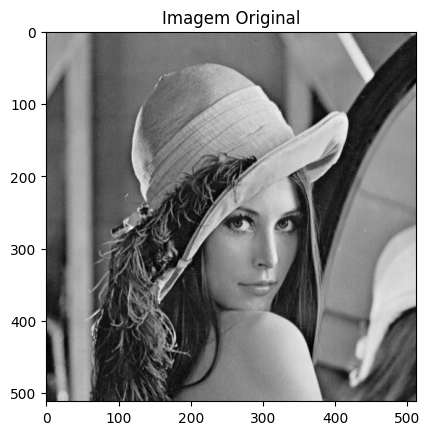

In [9]:
IMAGE_NAME = 'lena512'
ORIGINAL_IMAGE = cv2.imread(f'./imagens/{IMAGE_NAME}.pgm',0)
ORIGINAL_IMAGE_SHAPE = ORIGINAL_IMAGE.shape
plot_image(ORIGINAL_IMAGE, 'Imagem Original')

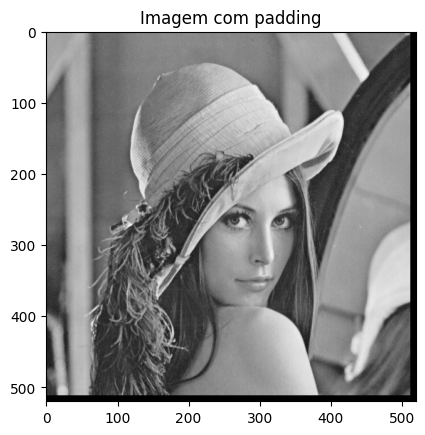

In [10]:
PADDED_IMAGE = add_padding(ORIGINAL_IMAGE, 8)
plot_image(PADDED_IMAGE, 'Imagem com padding')

In [11]:
type(ORIGINAL_IMAGE[0][0])

numpy.uint8

In [12]:
m = ORIGINAL_IMAGE# np.array([[1,2,3],[4,5,6],[7,8,9]]).astype(np.uint8)
print(calculate_entropy(m))

7.445506719708219


In [13]:
BLOCK_SIZE = 8

# Tirar os residuos/  Pegar os resíduos e transformar na imagem original - Giovana 

In [14]:
def get_left_column(macroblock):
    """
    Retrieves the last column of the given macroblock.
    """
    if macroblock is not None and macroblock.shape[1] > 0:
        return macroblock[:, -1]
    else:
        return None
    
def get_top_row(macroblock):
    """
    Retrieves the first row of the given macroblock.
    """
    if macroblock is not None and macroblock.shape[0] > 0:
        return macroblock[0, :]
    else:
        return None

    
def generate_macroblocks(img, block_size):
    """
    Generates macroblocks of a given size from the image.
    """
    for y in range(0, img.shape[0], block_size):
        for x in range(0, img.shape[1], block_size):
            macroblock = img[y:y+block_size, x:x+block_size]
            yield y, x, macroblock

def apply_horizontal_predictive(macroblock,left_column = None):
    """
    Applies a predictive function without loss on each macro block based on
    the formula f(x, y) = f(x, y) - f(x, y - 1).
    """
    new_block = np.zeros_like(macroblock, dtype=float)

    for i in range(macroblock.shape[0]):
        if left_column is not None:
            new_block[i, 0] = macroblock[i, 0] - left_column[i]
        else:
            new_block[i, 0] = macroblock[i, 0]

    for i in range(macroblock.shape[0]):
        for j in range(1, macroblock.shape[1]):
            new_block[i, j] = macroblock[i, j] - macroblock[i, j-1]
    return new_block

def apply_vertical_predictive(macroblock, top_row=None):
    """
    Applies a vertical predictive function on a given macroblock based on the formula
    f(x, y) = f(x, y) - f(x-1, y). 
    """
    new_block = np.zeros_like(macroblock, dtype=float)
    
    # Apply prediction for each element in the macroblock
    for j in range(macroblock.shape[1]):
        # Use top_row if available for the first row
        if top_row is not None:
            new_block[0, j] = macroblock[0, j] - top_row[j]
        else:
            new_block[0, j] = macroblock[0, j]  # Keep the real value if no top row
        
    for i in range(1,macroblock.shape[0]):
        for j in range(macroblock.shape[1]):
            new_block[i, j] = macroblock[i, j] - macroblock[i-1, j]
    
    return new_block


def process_image(img, block_size):
    """
    Processes the entire image by dividing it into macroblocks,
    applying the predictive function to each block, and 
    reconstructing the output image.
    """
    pred_img = np.zeros_like(img, dtype=float)
    last_macroblock = None
    
    for y, x, macroblock in generate_macroblocks(img, block_size):
        left_column = get_left_column(last_macroblock)
        top_row = get_top_row(last_macroblock)
        # new_block = apply_horizontal_predictive(left_column,macroblock.astype(float))
        new_block = apply_vertical_predictive(macroblock.astype(float),top_row)

        pred_img[y:y+block_size, x:x+block_size] = new_block

        last_macroblock = macroblock


    return pred_img


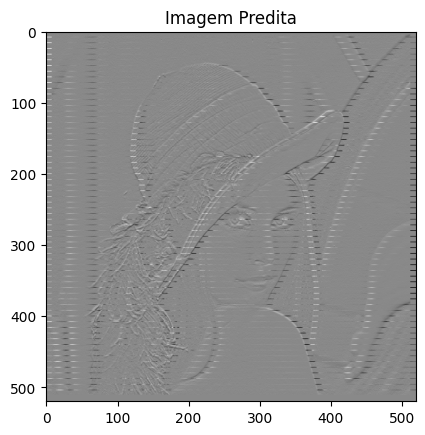

In [15]:
pred_img = process_image(PADDED_IMAGE, BLOCK_SIZE)
plot_image(pred_img, 'Imagem Predita')

# Fazer a tranformada/fazer a transformada inversa - Fernando


In [16]:
def get_dct(img):
    ''' 
    Get 2D Cosine Transform of Image
    '''
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_idct(coefficients):
    ''' 
    Get 2D Inverse Cosine Transform of Image
    '''
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def apply_image_transform(img, block_size, transform_function):
    '''
    Apply block-wise DCT or IDCT to an image.
    '''
    size = img.shape
    transformed_img = np.zeros(size, dtype=float)

    for y in range(0, size[0], block_size):
        for x in range(0, size[1], block_size):
            block = img[y:y+block_size, x:x+block_size]
            transformed_img[y:y+block_size, x:x+block_size] = transform_function(block)

    return transformed_img.astype(int)
    

In [17]:
transformed_img = apply_image_transform(pred_img, BLOCK_SIZE, get_dct)
type(transformed_img[0][0])

numpy.int64

In [18]:
calculate_entropy(ORIGINAL_IMAGE)

np.float64(7.445506719708219)

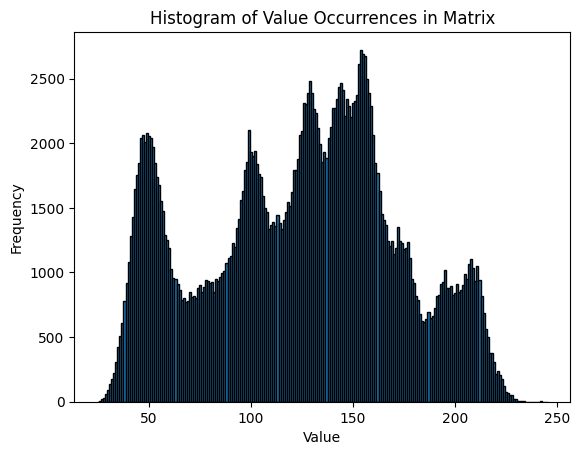

In [19]:
plot_histogram(ORIGINAL_IMAGE)

In [20]:
calculate_entropy(pred_img)

np.float64(5.004061629569532)

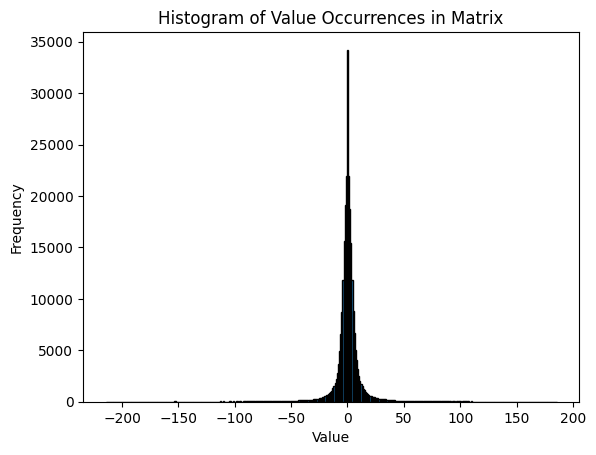

In [21]:
plot_histogram(pred_img)

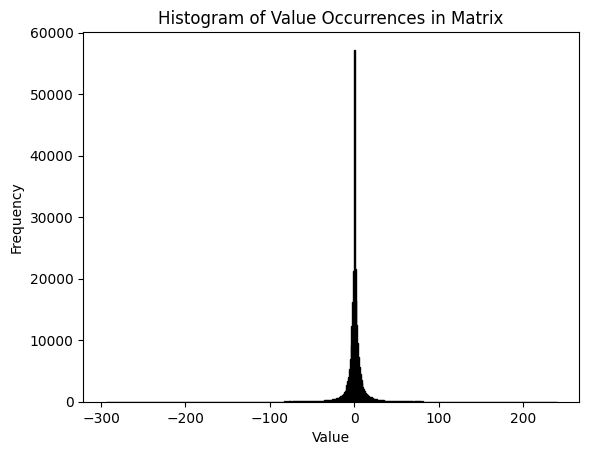

In [22]:
plot_histogram(transformed_img)

# Codificar/Decodidicar (huffman) - Araju


In [23]:
class Node:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(freq, symbol) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(left.freq + right.freq, left=left, right=right)
        heapq.heappush(heap, merged)

    return heap[0] if heap else None

def generate_huffman_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}

    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        generate_huffman_codes(node.left, prefix + "0", codebook)
        generate_huffman_codes(node.right, prefix + "1", codebook)

    return codebook


# Salvar no arquivo a imagem comprimida/ descomprimir a imagem -  Araju


In [24]:
def encode_data(data, huffman_codes):
    return ''.join(huffman_codes[symbol] for symbol in data)

def decode_data(encoded_data, huffman_codes):
    reverse_huffman_codes = {v: k for k, v in huffman_codes.items()}
    current_code = ""
    decoded_data = []

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_huffman_codes:
            decoded_data.append(reverse_huffman_codes[current_code])
            current_code = ""

    return decoded_data


def save_to_file(original_image_shape, filename, huffman_codes, encoded_data):
    with open(filename, 'wb') as file:
        file.write(struct.pack('<I', original_image_shape[0]))
        file.write(struct.pack('<I', original_image_shape[1]))
        # Save the number of unique symbols
        file.write(struct.pack('<I', len(huffman_codes)))

        # Save the Huffman codes
        for symbol, code in huffman_codes.items():
            file.write(struct.pack('<i', symbol))  # Symbol as 4 bytes
            file.write(struct.pack('<B', len(code)))  # Length of the code
            file.write(code.encode())  # Code as bytes

        # Save the length of the encoded data in bits
        file.write(struct.pack('<I', len(encoded_data)))
        # Convert the encoded data to bytes
        buffer = 0
        buffer_length = 0
        byte_array = bytearray()

        for bit in encoded_data:
            buffer = (buffer << 1) | int(bit)
            buffer_length += 1

            if buffer_length == 8:
                byte_array.append(buffer)
                buffer = 0
                buffer_length = 0

        if buffer_length > 0:
            buffer <<= (8 - buffer_length)
            byte_array.append(buffer)
        file.write(byte_array)

def load_from_file(filename):
    with open(filename, 'rb') as file:
        # Read the shape of the original image
        original_image_shape = (struct.unpack('<I', file.read(4))[0], struct.unpack('<I', file.read(4))[0])
        # Read the number of unique symbols
        num_symbols = struct.unpack('<I', file.read(4))[0]

        # Read the Huffman codes
        huffman_codes = {}
        for _ in range(num_symbols):
            symbol = struct.unpack('<i', file.read(4))[0]
            code_length = struct.unpack('<B', file.read(1))[0]
            code = file.read(code_length).decode()
            huffman_codes[symbol] = code

        # Read the length of the encoded data in bits
        encoded_data_length = struct.unpack('<I', file.read(4))[0]

        # Read the encoded data as bits
        encoded_data = ''
        while len(encoded_data) < encoded_data_length:
            byte = file.read(1)
            if not byte:
                break
            byte_value = ord(byte)
            encoded_data += f'{byte_value:08b}'

        return original_image_shape, huffman_codes, encoded_data[:encoded_data_length]

def huffman_encode_matrix(matrix):
    flat_list = [item for sublist in matrix for item in sublist]
    frequencies = Counter(flat_list)
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = generate_huffman_codes(huffman_tree)
    encoded_data = encode_data(flat_list, huffman_codes)
    return huffman_codes, encoded_data

def huffman_decode_matrix(encoded_data, huffman_codes, original_shape):
    decoded_flat_list = decode_data(encoded_data, huffman_codes)
    matrix = []
    index = 0
    for row_size in original_shape:
        matrix.append(decoded_flat_list[index:index + row_size])
        index += row_size
    return matrix



In [ ]:
# tamanho original da imagem
# opcao de predicao por macrobloco
# dicionario de huffman

In [29]:
# Random Matrix 8 x 8
matrix_to_save = np.random.randint(-128, 256, (8, 8))
original_shape = [len(row) for row in matrix_to_save]
huffman_codes, encoded_data = huffman_encode_matrix(matrix_to_save)
filename = f'{IMAGE_NAME}_compressed.gfa'
save_to_file(ORIGINAL_IMAGE_SHAPE, filename, huffman_codes, encoded_data)


loaded_orginal_image_shape, loaded_huffman_codes, loaded_encoded_data = load_from_file(filename)
decoded_matrix = huffman_decode_matrix(loaded_encoded_data, loaded_huffman_codes, loaded_orginal_image_shape)
print("orignal shape", ORIGINAL_IMAGE_SHAPE)
print("loaded shape: ", loaded_orginal_image_shape)
print(matrix_to_save)
print(decoded_matrix)
print((decoded_matrix == matrix_to_save).all())

orignal shape (512, 512)
loaded shape:  (512, 512)
[[ 176  -78  183  121   80  160  225  175]
 [  73  104  172   60   91  203   31  106]
 [ 209  188  113  -48 -111  190  171  -68]
 [  26   98   92  214  139  129  158  -58]
 [ 113  -67  141  238   -2  -87  -33  -74]
 [  44  -85  -68  177 -114  -67  166   47]
 [ 103  164  118  -55   80   54  116 -118]
 [ -93  243  130  151  -54   -3  -21   20]]
[[176, -78, 183, 121, 80, 160, 225, 175, 73, 104, 172, 60, 91, 203, 31, 106, 209, 188, 113, -48, -111, 190, 171, -68, 26, 98, 92, 214, 139, 129, 158, -58, 113, -67, 141, 238, -2, -87, -33, -74, 44, -85, -68, 177, -114, -67, 166, 47, 103, 164, 118, -55, 80, 54, 116, -118, -93, 243, 130, 151, -54, -3, -21, 20], []]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.